In [2]:
import numpy as np
from scipy.stats import laplace
from scipy.optimize import minimize
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from Master_Functions import *
from DeltaLaplaceFuncs import *

In [4]:
%load_ext autoreload
%autoreload 2


In [9]:
# Create toy data. We require X to be Laplace. 
X = laplace(0,1).rvs(10000)

#We'll also let Z be Delta_Laplace noise

#Condition on X being larger than some high quantile u

u = np.quantile(X,0.95)
X_data = X[X>u]

#We use a three-dimensional example, i.e., (X,Y) where Y is bivariate

locs=np.array([0.1,0.2])
cor=np.array([[1,0.6],
               [0.6,1]])
scales=np.array([0.7,0.8])
Cov=np.matmul(np.diag(scales),np.matmul(cor,np.diag(scales)))

shapes = np. array([2,2])

p = 2

Z = MultiDeltaLaplace(locs =locs,cov = Cov,shapes = shapes).rvs(size=len(X_data), random_state = 2)

alphas=np.array([0.6,0.7])
betas=np.array([0.3,0.3])

Y_data = np.matmul(np.array([X_data]*p).transpose(),np.diag(alphas)) + (np.asarray([x**beta for x,beta in zip(np.array([X_data]*p),betas)])*Z).transpose()

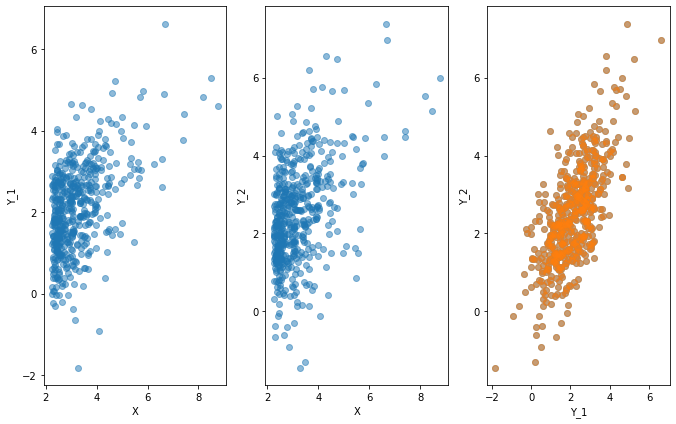

In [10]:

fig, axs = plt.subplots(1, 3, figsize=(9.5, 6))

for i in range(0,p):
    axs[i].scatter(X_data, Y_data[:,i], alpha=0.5)
    axs[i].set(xlabel="X", ylabel="Y_%i" %(i+1))
    
    axs[2].scatter(Y_data[:,0], Y_data[:,1], alpha=0.5)
    axs[2].set(xlabel="Y_1" , ylabel="Y_2" )
plt.tight_layout()
plt.show()

In [119]:
## Fit bivariate distribution. We will use Delta-Laplace margins. 
# Inputs: 
# X_data, shape = (n,)
# Y_data, shape = (p,)
# alpha_range = [0,1] - This is the range for alpha. Only supports single range across all alpha parameters
# par_len - The length of the input parameters. par_len[0] is number of alpha paramaters, par_len[1] : beta, par_len[2]: mu, par_len[3]: sigma, par_len[4] : delta. 
# Supports only one parameter for each variable or individual parameters for each variable i.e., par_len == 1 or p
# If par_len[4] = 0, will not use DL margins
# cor_len = Number of correlation parameters used. Supports either 1 or p(p-1)/2.
# x: parameter values. x[0:par_len[0]] gives alphas, x[par_len[0]:(par_len[0]+par_len[1])] gives betas etc.
# Note that correlation parameter values will be input to covariance matrix in the order $\rho_{12},\dots, \rho_{1d}, \rho_{23}, \dots, \rho_{2d}$ etc.


In [ ]:
# Easier to do an iterative fit i.e., calcualte pairwise parameters first

In [11]:
init_par=[0.7,0.4,0.3,0.2,2]


use_DL = True

fit1 = minimize(fun = CondExtBivNegLogLik,x0 = init_par,
               args=(X_data,Y_data[:,0],use_DL),
               method="Nelder-Mead")
fit1 = minimize(fun = CondExtBivNegLogLik,x0 = fit1.x,
               args=(X_data,Y_data[:,0],use_DL),
               method="BFGS")

print(fit1.x)

fit2 = minimize(fun = CondExtBivNegLogLik,x0 = init_par,
               args=(X_data,Y_data[:,1],use_DL),
               method="Nelder-Mead")
fit2 = minimize(fun = CondExtBivNegLogLik,x0 = fit2.x,
               args=(X_data,Y_data[:,1],use_DL),
               method="BFGS")

print(fit2.x)

[0.54433481 0.14487388 0.315645   0.80809625 1.91660065]
[0.50160717 0.42379666 0.54861181 0.71118548 1.68224401]


In [12]:
init_par=[fit1.x[0],fit2.x[0],fit1.x[1],fit2.x[1],fit1.x[2],fit2.x[2],fit1.x[3],fit2.x[3],fit1.x[4],fit2.x[4],0.4]
par_lens=[2,2,2,2,2]
cor_len=1
len(init_par)

11

In [16]:
# This is quite slow, and so I've used maxiter = 50. Hopefulyl increasing efficiency in future commits
fit = minimize(fun = CondExtMevNegLogLik,x0 = init_par,
               args=(X_data,Y_data,par_lens,cor_len),
               method="Nelder-Mead", options = {'maxiter' : 50})

fit

      fun: 1360.4963825592272
 hess_inv: array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])
      jac: array([-109.87261963,  -14.97467041,   20.24707031,  -40.49491882,
        -39.31942749,   -7.99255371,   30.86331177,  -49.93359375,
         -4.98770142,   -5.48580933,  -62.60842896])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 139
      nit: 0
     njev: 11
   status: 2
  success: False
        x: array([0.5304631 , 0.50303852, 0.15895158, 0.4013021 , 0.29316366,
       0.5283936 , 0.79116842, 0.69077487, 1.82264445, 1.62934847,
      

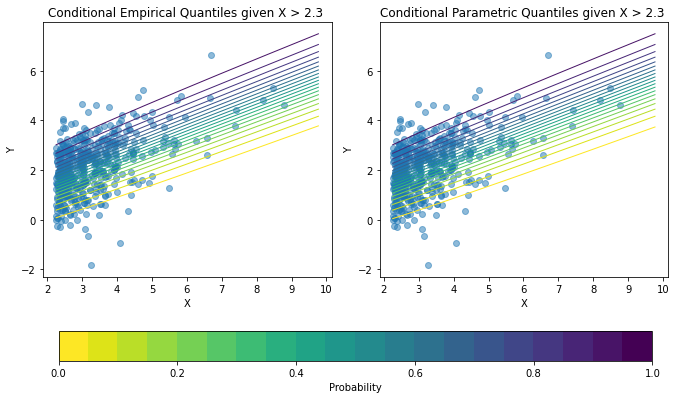

In [34]:
#Plot fits - Fit 1
from Master_Functions import plot_bivariate_condExt_fit

#This can be done using either the empirical residual quantiles or the parametric delta-Laplace quantiles. Choose between
#plot_type = ("Model","Empirical","Both")
#Other inputs:
#X,Y data for fitting - Can be unconditoned
#u - Threshold for conditional quantile Y| X > u. Should be greater than or equal to that used for fitting
#par_ests - parameter estimates. Only supports (alpha, beta, mu, sigma) or (alpha, beta, mu, sigma, delta)
#zoom - If True, plots only (X,Y)| X>u. Plots all data, otherwise.

u=min(X_data)
pars1=fit.x[(np.arange(0,9,2))]
plot_bivariate_condExt_fit(X = X_data,Y = Y_data[:,0],u = u, par_ests = pars1, probs = np.linspace(0.05,0.95,19), 
                           plot_type = "Both", zoom = False)


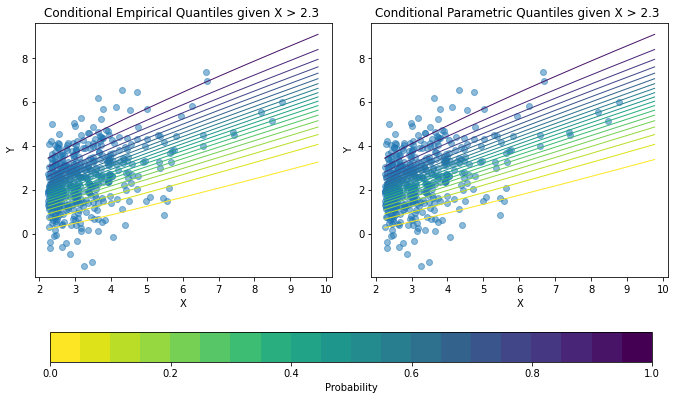

In [36]:
#Plot fits - Fit 2

u=min(X_data)
pars2=fit.x[(np.arange(1,10,2))]
plot_bivariate_condExt_fit(X = X_data,Y = Y_data[:,1],u = u, par_ests = pars2, probs = np.linspace(0.05,0.95,19), 
                           plot_type = "Both", zoom = False)

# Plot marginal quantiles on 3d plot

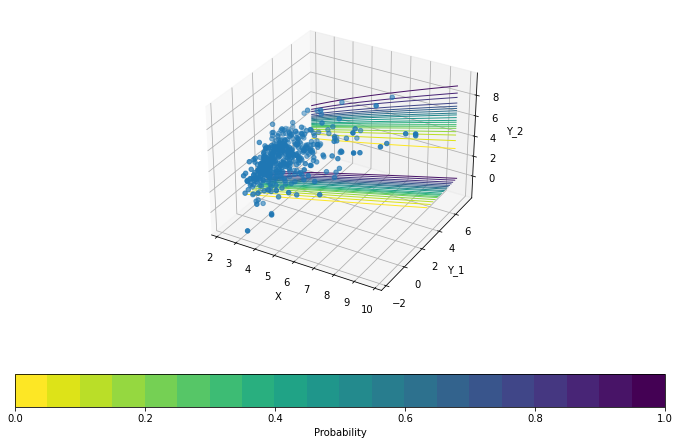

In [76]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors

fig = plt.figure(figsize=(9.5,6))
ax = Axes3D(fig)


ax.scatter(X_data, Y_data[:,0], Y_data[:,1])
ax.set_xlabel('X')
ax.set_ylabel('Y_1')

ax.set_zlabel('Y_2')

numer=(Y_data - np.matmul(np.array([X_data]*p).transpose(),np.diag(fit.x[0:2])))
denom = (np.asarray([x**beta for x,beta in zip(np.array([X_data]*p),fit.x[2:4])])).transpose()

Z_hat=numer/denom
probs=np.linspace(0.05, 0.95, 19)
quants1 = np.quantile(Z_hat[:,0], probs)
quants2 = np.quantile(Z_hat[:,1], probs)
cmap = plt.get_cmap('viridis_r', len(probs) + 1)

x_seq = np.linspace(u, max(X_data) + 1, 500)
for k in range(0, len(probs)):
    ax.plot(x_seq, fit.x[0] * x_seq + quants1[k] * (x_seq ** fit.x[2]),np.repeat(0,len(x_seq)), color=cmap.colors[k], linewidth=1)
    ax.plot(x_seq, np.repeat(7,len(x_seq)),fit.x[1] * x_seq + quants2[k] * (x_seq ** fit.x[3]), color=cmap.colors[k], linewidth=1)

norm = colors.Normalize(vmin=0., vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

fig.colorbar(sm, label="Probability", orientation="horizontal", shrink=0.95)

    


plt.show()